In [1]:
%matplotlib inline
import pprint  
import math
import numpy as np
import numpy.random as npr
import pandas as pd
import random
import warnings
import collections as ct
from scipy import stats
import scipy.stats as st
from scipy.stats import norm, rayleigh
import matplotlib
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from sklearn.utils.extmath import cartesian
from pylab import plot, show,hist,figure,title
from fitter import Fitter
import statsmodels.api as sm

/Users/gordontsai/anaconda3/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
income_model_dict = ct.OrderedDict()
income_model_dict['johnsonsu'] = st.johnsonsu(-5.3839367311065747,0.84376726932941271,-224.21280806585787,79.661998696081355)
income_model_dict['powerlaw'] = st.powerlaw(0.16342470577523971, -3.1423954341714262e-15, 55664716.096562646)
income_model_dict['exponpow'] = st.exponpow(0.25441022752240294, -1.8475789041433829e-22, 36120900.670255348)
income_model_dict['nakagami'] = st.nakagami(0.10038339454419823, -3.0390927147076284e-22, 33062195.426077582)
income_model_dict['exponweib'] = st.exponweib(-3.5157658448986489, 0.44492833350419714, -15427.454196748848, 2440.0278856175246)

In [3]:
drivingdistance_model_dict = ct.OrderedDict()
drivingdistance_model_dict['nakagami'] = st.nakagami(0.11928581143831021, 14.999999999999996, 41.404620910360876)
drivingdistance_model_dict['ncx2'] = st.ncx2(0.30254190304723211, 1.1286538320791935, 14.999999999999998, 8.7361471573932192)
drivingdistance_model_dict['chi'] = st.chi(0.47882729877571095, 14.999999999999996, 44.218301183844645)
drivingdistance_model_dict['recipinvgauss'] = st.recipinvgauss(2447246.0546641815, 14.999999999994969, 31.072009722580802)
drivingdistance_model_dict['f'] = st.f(0.85798489720127036, 4.1904554804436929, 14.99998319939356, 21.366492843433996)

In [4]:
drivingduration_model_dict = ct.OrderedDict()
drivingduration_model_dict['betaprime'] = st.betaprime(2.576282082814398, 9.7247974165209996, 9.1193851632305201, 261.3457987967214)
drivingduration_model_dict['exponweib'] = st.exponweib(2.6443841639764942, 0.89242254172118096, 10.603640861374947, 40.28556311444698)
drivingduration_model_dict['gengamma'] = st.gengamma(4.8743515108339581, 0.61806208678747043, 9.4649293818479716, 5.431576919220225)
drivingduration_model_dict['recipinvgauss'] = st.recipinvgauss(0.499908918842556, 0.78319699707613699, 28.725450197674746)
drivingduration_model_dict['f'] = st.f(9.8757694313677113, 12.347442183821462, 0.051160749890587665, 73.072591767722287)

In [5]:
carprice_model_dict = ct.OrderedDict()
carprice_model_dict['nct'] = st.nct(7.3139456577106312, 3.7415255108348946, -46.285705145385577, 7917.0860181436065)
carprice_model_dict['genlogistic'] = st.genlogistic(10.736440967148635, 3735.7049978006107, 10095.421377235754)
carprice_model_dict['gumbel_r'] = st.gumbel_r(26995.077239517472, 10774.370808211244)
carprice_model_dict['f'] = st.f(24168.523476867485, 35.805656864712923, -21087.314142557225, 51154.0328397044)
carprice_model_dict['johnsonsu'] = st.johnsonsu(-1.7479864366935538, 1.8675670208081987, 14796.793096897647, 14716.575397771712)

In [6]:
###Feed in dictionary of model distributions and the model number you want, spits out the model
def selectModel(model_dict,model_number): #model_number goes from 1-5, 1 being best, 5 being worst
    name = []
    model_function = []
    for k,v in model_dict.items():
        name.append(k)
        model_function.append(v)

    model = model_function[model_number]
    
    return model

In [7]:
def avgMPH(annualMiles):
    if annualMiles/365>100:
        mph = 60
    elif annualMiles/365 >50:
        mph = 40
    elif annualMiles/365 > 30:
        mph = 35
    elif annualMiles/365 > 20:
        mph = 30
    else:
        mph = 25
    return mph

In [8]:
simsize = 100000
# Time_Worth = npr.normal(loc =150, scale = 30,size=simsize)
# Car_Price = npr.normal(loc = 24000, scale = 2400,size=simsize)
# Annual_Miles_Avg = npr.normal(loc = 9000, scale =900,size=simsize)

Time_Worth = 55
Car_Price = 50000
Annual_Miles_Avg = 13000

##############################################################################################################
#EconomicParameters
Model_Length = 20 # as years
MPG = 25
Fuel_Price = 2.5  # as $/gal
#Trip_Time_Avg = 10  # as num
Num_Trips_Avg = 2  # as num

MPG = float(MPG)    
Fuel_Price = float(Fuel_Price)

Num_Trips_Avg = float(Num_Trips_Avg)

if isinstance(Time_Worth, np.ndarray):
    Time_Worth = [float(Time_Worth[i]) for i in range(0,Time_Worth.size-1)] 
else: 
    Time_Worth = float(Time_Worth)

if isinstance(Annual_Miles_Avg, np.ndarray):
    Annual_Miles_Avg = [float(Annual_Miles_Avg[i]) for i in range(0,Annual_Miles_Avg.size-1)] 
else:
    Annual_Miles_Avg = float(Annual_Miles_Avg)

if isinstance(Car_Price, np.ndarray):
    Car_Price = [float(Car_Price[i]) for i in range(0,Car_Price.size-1)] 
else:
    Car_Price = float(Car_Price)

#Global Inputs, Calculated
Daily_Miles_Avg = Annual_Miles_Avg/365
Trip_Dist_Avg = Daily_Miles_Avg/Num_Trips_Avg
Trip_Time_Avg = Daily_Miles_Avg/avgMPH(Annual_Miles_Avg)/Num_Trips_Avg*60 #as minutes 
#Daily_Miles_Avg = [x / 365 for x in Annual_Miles_Avg]   # as miles/day
#Trip_Dist_Avg = [x / Num_Trips_Avg for x in Daily_Miles_Avg]
#Drive_Time_Avg = Trip_Time_Avg*Num_Trips_Avg   # as minutes

Trip_Time_Avg = float(Trip_Time_Avg)

######################################################################################################################
#Traditional Car Ownership Model 
#Expenses to Purchase Car, Hardcoded
#Car_Price = 24000 #as $
Sales_Tax_Percent = .0625 #as decimal percent
Purchase_Fees = 250  # as $ for maybe title transfer
Down_Payment = 5000 #as $
Loan_Terms = 48 #as months
AIR = .03 #as decimal percent

Sales_Tax_Percent = float(Sales_Tax_Percent)
Purchase_Fees = float(Purchase_Fees)
Down_Payment = float(Down_Payment)
Loan_Terms = float(Loan_Terms)
AIR = float(AIR)
#Expenses to Purchase Car, Calculated
#Sales_Tax_Num = Car_Price*Sales_Tax_Percent #as $
#Loan_Amount = Car_Price - Down_Payment #as $
#used in car_ownership now
MIR = AIR/12
#Monthly_PMT = (MIR*Loan_Amount*(1+MIR)**Loan_Terms)/(((1+MIR)**Loan_Terms)-1)
#included in Car_Ownership Model

##################################################################################################################
#Direct Expenses to Own Car Avg'd over 10 years
Maint_Repairs_Exp = 1250 # as $
Insurance_Exp = 1000 # as $
Registr_Taxes_Exp = 150 # as $
Parking_Exp = 200 # as $
Maint_Repairs_Exp = float(Maint_Repairs_Exp)
Insurance_Exp = float(Insurance_Exp)
Registr_Taxes_Exp = float(Registr_Taxes_Exp)
Parking_Exp = float(Parking_Exp)


#Now in Car_Ownership
#Fuel_Exp = [Annual_Miles_Avg[i]/MPG[i]*Fuel_Price[i] for i in range(0,simsize-1)]
#Total_DE = Maint_Repairs_Exp+Insurance_Exp+Registr_Taxes_Exp+Parking_Exp+Fuel_Exp

#####################################################################################################################
#-----------Uber Model
#-----Expenses for Hiring
Fare_Base = 2 # as $
Fare_Per_Mile = 1.50 # as $/mile
Fare_Per_Minute = .20 # as $/minute
# Fare_Base = 1 # as $
# Fare_Per_Mile = .750 # as $/mile
# Fare_Per_Minute = .10 # as $/minute
#In Uber_Model

#In Uber_Model
#Uber_Exp_Annual = Uber_Exp_Daily*365
Min_Fee_Uber = 6.0 # as $
Cancel_Fee_Uber = 8.0 # as $
Fare_Base = float(Fare_Base)
Fare_Per_Mile = float(Fare_Per_Mile)
Fare_Per_Minute = float(Fare_Per_Minute)

Uber_Trip_Avg = Fare_Base+Fare_Per_Mile*Trip_Dist_Avg+Fare_Per_Minute*Trip_Time_Avg
Uber_Trip_Avg = float(Uber_Trip_Avg)
Uber_Exp_Daily =  Uber_Trip_Avg*Num_Trips_Avg

#Uber_Exp_Annual = float(Uber_Exp_Annual)
Min_Fee_Uber = float(Min_Fee_Uber)
Cancel_Fee_Uber = float(Cancel_Fee_Uber)

#---Annual Value of Time
Wait_Time_Uber_Avg = 5.0 # as minutes 
Wait_Time_Uber_Avg = float(Wait_Time_Uber_Avg)
#Add to Uber Model
#Val_Time_Daily_Uber = (Wait_Time_Uber_Avg*Num_Trips_Avg)/60*Time_Worth
#Val_Time_Annual_Uber = Val_Time_Daily_Uber*365
###############################################################################################################
#Annual Indirect Expenses Avg'd over 10 years
Property_Tax_Garage_IDE= 300 # as $ Garage might be worth $15k; if property tax 2%; garage $300/year
Garage_Repair_IDE_Ann = 200 # as $
Property_Tax_Garage_IDE = float(Property_Tax_Garage_IDE)
Garage_Repair_IDE_Ann = float(Garage_Repair_IDE_Ann)
Total_IDE = Property_Tax_Garage_IDE+Garage_Repair_IDE_Ann

#Annual Value of Time
Walk_Time_Avg= 20 # as minutes
Walk_Time_Avg = float(Walk_Time_Avg)
#Val_Drive_Time_Daily = Time_Worth*Drive_Time_Avg/60
#Val_Walk_Time_Daily = Walk_Time_Avg/60*Time_Worth
#Val_Time_Daily_Car =Val_Drive_Time_Daily+Val_Walk_Time_Daily
#Val_Time_Annual_Car = (Val_Time_Daily_Car)*365
#used in CarOwnership Function now
#---------------------------------------------------------------------------

In [9]:
#####################################################################################################################
def Amortization(mnth = 12,loanterms= Loan_Terms, ir = MIR,carprice= Car_Price, downpmnt = Down_Payment): 
    loan = carprice-downpmnt #as $
    pmnt = (ir*loan*(1+ir)**loanterms)/(((1+ir)**loanterms)-1)

    #Test
    #print(pmnt)
    #print(ir)
    #print(loan)
    #print(Loan_Terms)
    #print(mnth)
    
    #Year1 Values
    Interest_1 = loan*ir
    #print(Interest_1)
    Principal_1 = pmnt-Interest_1
    #print(Principal_1)
    Balance_1 = loan-Principal_1
    Interest = ir*Balance_1
    Balance = Balance_1
    Total_Principal = Principal_1
    Total_Interest = Interest_1
    Total_Pmnt = pmnt*mnth
    #print(Total_Pmnt)
    for i in range(0,int(mnth-1)):
        Interest = ir*Balance
        Principal = pmnt-Interest
        Balance = Balance-Principal
        Total_Principal = Principal+Total_Principal
        Total_Interest = Interest +Total_Interest
    if mnth==1:
        return pmnt, pmnt, Interest_1, Interest_1, Principal_1, Principal_1, Balance_1
    else:
        return pmnt,Total_Pmnt,Interest,Total_Interest,Principal,Total_Principal,Balance
    

#Test    
#Amortization(mnth = 12,carprice=Car_Price[0])
#print(a,b,c,d,e,f,g)


In [10]:
#####################################################################################################################

def Uber_Expense_Model(outputyears = (7,10,15,20), annualroi = 5,
                       farebase = Fare_Base, farepermile = Fare_Per_Mile, farepermin = Fare_Per_Minute,
                       annualmiles = Annual_Miles_Avg, triptime = Trip_Time_Avg, numtrips = Num_Trips_Avg,
                       timeworth= Time_Worth, waittime = Wait_Time_Uber_Avg, carprice = Car_Price):
    #Calc Val_Time_Annual_Uber
    Val_Time_Daily_Uber = (waittime*numtrips)/60*timeworth
    valuetime = Val_Time_Daily_Uber*365
    
    #Calc Trip_Dist_Avg
    Daily_Miles_Avg = annualmiles/365   # as miles/day
    Trip_Dist_Avg = Daily_Miles_Avg/numtrips
        
    #Calc Uber_Exp_Annual
    Uber_Trip_Avg = farebase+farepermile*Trip_Dist_Avg+farepermin*triptime
    Uber_Exp_Daily =  Uber_Trip_Avg*Num_Trips_Avg
    annualexpense = Uber_Exp_Daily*365
    
    a,OUP_Expense_Car,Cum_Expense_Car = Car_Ownsership_Expense_Model(annualmiles=annualmiles,timeworth=timeworth, carprice= carprice)
    #Convert annualroi to float
    annualroi = float(annualroi)

    array = np.zeros((10,len(OUP_Expense_Car)))
    #Annual Fee to TNC
    array[0] = annualexpense
    #Value of Time Expense
    array[1] = valuetime
    #Total OUP Expense
    array[2] = array[0] + array[1] 
    #Cum. OOP Expense
    for i in range(0,len(OUP_Expense_Car)):
        if i==0:
            array[3,i]=array[2,i]
        else:
            array[3,i]=array[3,i-1]+array[2,i]	
    #Unrealized Annual Cash Savings
    array[4] = array[2] - OUP_Expense_Car
    #Cum Unrealized Cash Savings
    for i in range(0,len(OUP_Expense_Car)):
        if i==0:
            array[5,i]=array[4,i]
        else:
            array[5,i]=array[5,i-1]+array[4,i]	
    ##Unrealized Value of Invested Savings
    for i in range(0,len(OUP_Expense_Car)):
        if i==0:
            array[6,i]=array[4,i]
        else:
            array[6,i]=array[4,i]+(array[6,i-1]*(1+annualroi/100))
    #Unrealized Added Value of Investing
    array[7] = array[6]-array[5]

    #Total Expense for Using Uber
    array[8] = array[3]+array[7]

    #Expense Delta
    array[9] = Cum_Expense_Car-array[8]

    #output array
    output = np.zeros((1,len(outputyears)))
    for i in range(0,len(outputyears)):
        output[0,i] = array[8,outputyears[i]-1]
    return output

#Test
#a = Uber_Expense_Model(timeworth=Time_Worth[0],annualmiles=Annual_Miles_Avg[0],carprice = Car_Price[0])
#print(a)
###################################################################################################################

In [11]:
#####################################################################################################################
def Car_Ownsership_Expense_Model(outputyears = (7,10,15,20), n = [7,10,15,20], purchasefees = Purchase_Fees, 
                                 downpmnt = Down_Payment,ide = Total_IDE, timeworth= Time_Worth,
                                 annualmiles = Annual_Miles_Avg, loanterms = Loan_Terms,
     years= Model_Length,carprice = Car_Price, milespergallon = MPG, triptime = Trip_Time_Avg,
         fuelprice = Fuel_Price, numtrips = Num_Trips_Avg, taxpercent = Sales_Tax_Percent,
         maintenance = Maint_Repairs_Exp, insurance = Insurance_Exp,registrationtaxes = Registr_Taxes_Exp,
        parking = Parking_Exp):
    
    
    Fuel_Exp = annualmiles/milespergallon*fuelprice
    de = maintenance+insurance+registrationtaxes+parking+Fuel_Exp
    
    
    salestax = carprice*taxpercent #as $
    Loan_Amount = carprice - Down_Payment #as $
    
    
    Daily_Miles_Avg = annualmiles/365   # as miles/day
    Trip_Dist_Avg = Daily_Miles_Avg/numtrips
    Drive_Time_Avg = triptime*numtrips   # as minutes
    
    #timeworth is in here
    Val_Drive_Time_Daily = timeworth*Drive_Time_Avg/60
    Val_Walk_Time_Daily = Walk_Time_Avg/60*timeworth
    Val_Time_Daily_Car =Val_Drive_Time_Daily+Val_Walk_Time_Daily
    Val_Time_Annual_Car = (Val_Time_Daily_Car)*365
    valuetime = Val_Time_Annual_Car

    
    loanyears = loanterms/12
    array = np.zeros((13,years))
    [rows,columns] = array.shape
    [a,b,c,d,e,f,g] = Amortization(mnth=12,carprice=carprice)
    Principal_Incr = f 
    Interest_Incr = d
    
    #Test
    #print(a,b,c,de,f,g)
    #print(Principal_Incr)
    #print(Interest_Incr)
    
    #assigning Cost at Time of Purchase
    cost = salestax+purchasefees+downpmnt
    array[0,0] = cost
    #Principal Paid and Interest Paid
    for i in range(0,columns):
        if i > loanyears-1:
            array[1,i] = 0.0
            array[2,i] = 0.0
        elif i == 0:
            array[1,i] = Principal_Incr
            array[2,i] = Interest_Incr
        else:
            [a,b,c,d,e,f,g] = Amortization(mnth=(i+1)*12,carprice=carprice)
            [h,j,k,l,m,n,o] = Amortization(mnth = i*12,carprice=carprice)
            Principal_Incr = f-n
            Interest_Incr = d-l
            array[1,i] = Principal_Incr
            array[2,i] = Interest_Incr

    #Assigning DE and IDE
    array[3] = de
    array[4] = ide

    #Summing expense Total Value Out of Pocket Expense and Cumulative Out of Pocket Expense
    array[5] = array[0]+array[1]+array[2]+array[3]+array[4]
    for i in range(0,columns):
        if i==0:
            array[6,i]=array[5,i]
        else:
            array[6,i]=array[5,i]+array[6,i-1]

    #Annual Value of Time and Cumulative Value of Time
    array[7] = valuetime
    for i in range(0,columns):
        if i==0:
            array[8,i]=array[7,i]
        else:
            array[8,i]=array[7,i]+array[8,i-1]	

    #Total Annual Expense for Owning and Cum. Expense for Owning
    array[9] = array[7] +array[5]
    for i in range(0,columns):
        if i==0:
            array[10,i]=array[9,i]
        else:
            array[10,i]=array[9,i]+array[10,i-1]

    #Value of Car
    array[11] = Depreciation(20,4)*carprice

    #Cumulative Expenses Less value of Car
    array[12] = array[10] - array[11]
    
    output = np.zeros((2,len(outputyears)))
    for i in range(0,len(outputyears)):
        output[0,i] = array[10,outputyears[i]-1]
        output[1,i] = array[12,outputyears[i]-1]


    return output,array[5],array[10]



#Test
#output_year = (10,)
#i = 0
#a,b,c = Car_Ownsership_Expense_Model(outputyears=output_year,annualmiles = Annual_Miles_Avg[i],carprice=Car_Price[i],timeworth= Time_Worth[i])
#print(a)

#Test
#a,b,c = Car_Ownsership_Expense_Model(annualmiles = Annual_Miles_Avg[0],carprice=Car_Price[0],timeworth= Time_Worth[0])
#print(a)

In [12]:
#####################################################################################################################
def Depreciation(initialrate,rate,years = Model_Length):
    years = int(math.ceil(years))
    array = np.zeros((1,years))
    initialrate = initialrate/100.0
    rate = rate/100.0
    totalpercent = 1.0
    for i in range(0,(array.size)):
        if initialrate>.1:
            array[0][i] = totalpercent*(1-initialrate)
            initialrate = initialrate - rate
            totalpercent= array[0][i]
        else:
            array[0][i] = totalpercent*(1-.1)
            totalpercent= array[0][i]
    return array

In [13]:
#Single Test Case used to verify model matches excel document
output_year = (7,)

a,b,c = Car_Ownsership_Expense_Model(outputyears= output_year,annualmiles = Annual_Miles_Avg,carprice=Car_Price,timeworth= Time_Worth)
d = Uber_Expense_Model(outputyears= output_year,timeworth=Time_Worth,annualmiles=Annual_Miles_Avg,carprice = Car_Price)

# a is the array output of [Cumulative Expense for Owning, Cumulative Expenses (Less Value of Car)]

In [14]:
simsize = 100000

Time_Worth = selectModel(income_model_dict,0).rvs(size = simsize)/2000
Annual_Miles_Avg = selectModel(drivingdistance_model_dict,0).rvs(size = simsize)*365
Annual_Miles_Time = selectModel(drivingduration_model_dict,0).rvs(size = simsize)
Car_Price = selectModel(carprice_model_dict,0).rvs(size = simsize)

In [15]:
#EconomicParameters
Model_Length = 20 # as years
MPG = 25
Fuel_Price = 2.5  # as $/gal
#Trip_Time_Avg = 10  # as num
Num_Trips_Avg = 2  # as num #############Change this back to 3 later

MPG = float(MPG)    
Fuel_Price = float(Fuel_Price)
#Trip_Time_Avg = float(Trip_Time_Avg)
Num_Trips_Avg = float(Num_Trips_Avg)

if isinstance(Time_Worth, np.ndarray):
    Time_Worth = [float(Time_Worth[i]) for i in range(0,Time_Worth.size)] 
else: 
    Time_Worth = float(Time_Worth)

if isinstance(Annual_Miles_Avg, np.ndarray):
    Annual_Miles_Avg = [float(Annual_Miles_Avg[i]) for i in range(0,Annual_Miles_Avg.size)] 
else:
    Annual_Miles_Avg = float(Annual_Miles_Avg)

if isinstance(Car_Price, np.ndarray):
    Car_Price = [float(Car_Price[i]) for i in range(0,Car_Price.size)] 
else:
    Car_Price = float(Car_Price)

#Global Inputs, Calculated
Daily_Miles_Avg = [(Annual_Miles_Avg[i]/365) for i in range(0,len(Annual_Miles_Avg))]   # as miles/day
Trip_Dist_Avg = [Daily_Miles_Avg[i]/Num_Trips_Avg for i in range(0,len(Daily_Miles_Avg))]
Trip_Time_Avg = [Daily_Miles_Avg[i]/avgMPH(Annual_Miles_Avg[i])/Num_Trips_Avg*60 for i in range(0,len(Daily_Miles_Avg))] #as minutes 
    
######################################################################################################################
#Traditional Car Ownership Model 
#Expenses to Purchase Car, Hardcoded
#Car_Price = 24000 #as $
Sales_Tax_Percent = .0625 #as decimal percent
Purchase_Fees = 250  # as $ for maybe title transfer
Down_Payment = 5000 #as $
Loan_Terms = 48 #as months
AIR = .03 #as decimal percent

Sales_Tax_Percent = float(Sales_Tax_Percent)
Purchase_Fees = float(Purchase_Fees)
Down_Payment = float(Down_Payment)
Loan_Terms = float(Loan_Terms)
AIR = float(AIR)
#Expenses to Purchase Car, Calculated
#Sales_Tax_Num = Car_Price*Sales_Tax_Percent #as $
#Loan_Amount = Car_Price - Down_Payment #as $
#used in car_ownership now
MIR = AIR/12
#Monthly_PMT = (MIR*Loan_Amount*(1+MIR)**Loan_Terms)/(((1+MIR)**Loan_Terms)-1)
#included in Car_Ownership Model

##################################################################################################################
#Direct Expenses to Own Car Avg'd over 10 years
Maint_Repairs_Exp = 1250 # as $
Insurance_Exp = 1000 # as $
Registr_Taxes_Exp = 150 # as $
Parking_Exp = 200 # as $
Maint_Repairs_Exp = float(Maint_Repairs_Exp)
Insurance_Exp = float(Insurance_Exp)
Registr_Taxes_Exp = float(Registr_Taxes_Exp)
Parking_Exp = float(Parking_Exp)

#Now in Car_Ownership
#Fuel_Exp = [Annual_Miles_Avg[i]/MPG[i]*Fuel_Price[i] for i in range(0,simsize-1)]
#Total_DE = Maint_Repairs_Exp+Insurance_Exp+Registr_Taxes_Exp+Parking_Exp+Fuel_Exp

#####################################################################################################################
#-----------Uber Model
#-----Expenses for Hiring
Fare_Base = 2 # as $
Fare_Per_Mile = 1.50 # as $/mile
Fare_Per_Minute = .20 # as $/minute
# Fare_Base = 1 # as $
# Fare_Per_Mile = .750 # as $/mile
# Fare_Per_Minute = .10 # as $/minute
#In Uber_Model

#In Uber_Model
#Uber_Exp_Annual = Uber_Exp_Daily*365
Min_Fee_Uber = 6.0 # as $
Cancel_Fee_Uber = 8.0 # as $
Fare_Base = float(Fare_Base)
Fare_Per_Mile = float(Fare_Per_Mile)
Fare_Per_Minute = float(Fare_Per_Minute)

#Uber_Trip_Avg = Fare_Base+Fare_Per_Mile*Trip_Dist_Avg+Fare_Per_Minute*Trip_Time_Avg
#Uber_Trip_Avg = float(Uber_Trip_Avg)
#Uber_Exp_Daily =  Uber_Trip_Avg*Num_Trips_Avg


#Uber_Exp_Annual = float(Uber_Exp_Annual)
Min_Fee_Uber = float(Min_Fee_Uber)
Cancel_Fee_Uber = float(Cancel_Fee_Uber)

#---Annual Value of Time
Wait_Time_Uber_Avg = 5.0 # as minutes 
Wait_Time_Uber_Avg = float(Wait_Time_Uber_Avg)
#Add to Uber Model
#Val_Time_Daily_Uber = (Wait_Time_Uber_Avg*Num_Trips_Avg)/60*Time_Worth
#Val_Time_Annual_Uber = Val_Time_Daily_Uber*365
###############################################################################################################
#Annual Indirect Expenses Avg'd over 10 years
Property_Tax_Garage_IDE= 300 # as $ Garage might be worth $15k; if property tax 2%; garage $300/year
Garage_Repair_IDE_Ann = 200 # as $
Property_Tax_Garage_IDE = float(Property_Tax_Garage_IDE)
Garage_Repair_IDE_Ann = float(Garage_Repair_IDE_Ann)
Total_IDE = Property_Tax_Garage_IDE+Garage_Repair_IDE_Ann

#Annual Value of Time
Walk_Time_Avg= 20 # as minutes
Walk_Time_Avg = float(Walk_Time_Avg)
#Val_Drive_Time_Daily = Time_Worth*Drive_Time_Avg/60
#Val_Walk_Time_Daily = Walk_Time_Avg/60*Time_Worth
#Val_Time_Daily_Car =Val_Drive_Time_Daily+Val_Walk_Time_Daily
#Val_Time_Annual_Car = (Val_Time_Daily_Car)*365
#used in CarOwnership Function now
#---------------------------------------------------------------------------


In [16]:
#Monte Carlo Simulation
output_year = (7,)
Decision = np.zeros((1,simsize))
Car_NPV = []
Uber_NPV = []

for i in range(0,simsize-1):
#     print 'Time Worth', Time_Worth[i]
#     print 'Annual_Miles_Avg Worth', Annual_Miles_Avg[i]
#     print 'Car Price', Car_Price[i]
    
    a,b,c = Car_Ownsership_Expense_Model(outputyears=output_year,annualmiles = Annual_Miles_Avg[i],carprice=Car_Price[i],timeworth= Time_Worth[i], triptime= Trip_Time_Avg[i])
    d = Uber_Expense_Model(outputyears= output_year,timeworth=Time_Worth[i],annualmiles=Annual_Miles_Avg[i],carprice = Car_Price[i],triptime= Trip_Time_Avg[i])
    Car_NPV.append(a)
    Uber_NPV.append(d)

#     print 'Car Own Cost', a[0]
#     print 'Uber Cost', d
    #d is expense of ubering
    Decision[0,i] = a[0]-d





In [17]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

In [18]:
Decision = np.transpose(Decision)
n_bins=100
Decision=Decision/1000

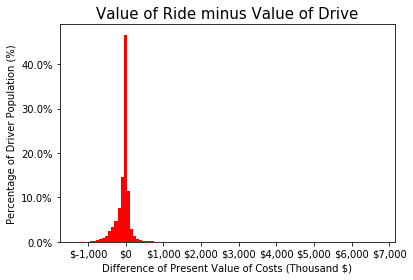

In [19]:
plt.ylabel('Percentage of Driver Population (%)',size=10)
plt.xlabel('Difference of Present Value of Costs (Thousand $)',size=10)


#Computes a frequency histogram instad of a probabilty density histogram.
#This means the height of the bars sum to 1.
#Normally if you use density=True you get a probability density histogrram where the area of the graph sums to one.
weights = np.ones_like(Decision)/float(len(Decision))
N, bins, patches=plt.hist(Decision, weights=weights,bins=n_bins,color='xkcd:sky blue')

# N, bins, patches =plt.hist(Decision, bins=n_bins, density=True)
#plt.style.use('dark_background')
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax=plt.gca()
plt.title('Value of Ride minus Value of Drive',size=15)
ax.xaxis.set_major_formatter(tick) 

# patches.set_fill(True)

for i in np.arange(0,33,1):
    patches[i].set_fc('r')

#Trying to format y axis
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

# Figure size
# plt.figure(figsize=(15,15))
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

figure=plt.gcf()
plt.savefig('montecarlo.png',dpi=500,bbox_inches='tight')

mean = np.mean(Decision)

In [20]:
Decision.max()

6734.051840202259

In [21]:
Uber_wins = 0 
Car_wins = 0
for i in range(0,len(Decision)):
    if Decision[i] < 0:
        Car_wins += 1
    else:
        Uber_wins += 1

Uber_percent = float(Uber_wins)/len(Decision)
Car_percent = float(Car_wins)/len(Decision)

In [22]:
print(Uber_percent, 'of the US is better off Ubering')
print(Car_percent, 'of the US is better off Car Owning')

0.30941 of the US is better off Ubering
0.69059 of the US is better off Car Owning


In [23]:
###########################################################
#Producing Cost Per Ride to Percentage Plot

# cost_per_mile=np.arange(.1,3.1,.1)
cost_per_mile=np.array([.02,.06,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. ])
cost_per_ride=[]

for x in range(0,len(cost_per_mile)):

    #Monte Carlo Simulation
    output_year = (7,)
    Decision = np.zeros((1,simsize))
    Car_NPV = []
    Uber_NPV = []

    for i in range(0,simsize-1):
    #     print 'Time Worth', Time_Worth[i]
    #     print 'Annual_Miles_Avg Worth', Annual_Miles_Avg[i]
    #     print 'Car Price', Car_Price[i]

        a,b,c = Car_Ownsership_Expense_Model(outputyears=output_year,annualmiles = Annual_Miles_Avg[i],carprice=Car_Price[i],timeworth= Time_Worth[i], triptime= Trip_Time_Avg[i])
        d = Uber_Expense_Model(farepermile=cost_per_mile[x],outputyears= output_year,timeworth=Time_Worth[i],annualmiles=Annual_Miles_Avg[i],carprice = Car_Price[i],triptime= Trip_Time_Avg[i])
        Car_NPV.append(a)
        Uber_NPV.append(d)

    #     print 'Car Own Cost', a[0]
    #     print 'Uber Cost', d
        #d is expense of ubering
        Decision[0,i] = a[0]-d



    Decision = np.transpose(Decision)
    n_bins=100
    Decision=Decision/1000 


    Uber_wins = 0 
    Car_wins = 0
    for i in range(0,len(Decision)):
        if Decision[i] < 0:
            Car_wins += 1
        else:
            Uber_wins += 1

    Uber_percent = float(Uber_wins)/len(Decision)
    Car_percent = float(Car_wins)/len(Decision)
    
    print("Cost Per Mile is ", cost_per_mile[x])
    print(Uber_percent, 'of the US is better off Ubering')
    print(Car_percent, 'of the US is better off Car Owning')

    cost_per_ride.append((cost_per_mile[x],Uber_percent))


Cost Per Mile is  0.02
0.99625 of the US is better off Ubering
0.00375 of the US is better off Car Owning
Cost Per Mile is  0.06
0.98841 of the US is better off Ubering
0.01159 of the US is better off Car Owning
Cost Per Mile is  0.1
0.97485 of the US is better off Ubering
0.02515 of the US is better off Car Owning
Cost Per Mile is  0.2
0.92871 of the US is better off Ubering
0.07129 of the US is better off Car Owning
Cost Per Mile is  0.3
0.87926 of the US is better off Ubering
0.12074 of the US is better off Car Owning
Cost Per Mile is  0.4
0.82871 of the US is better off Ubering
0.17129 of the US is better off Car Owning
Cost Per Mile is  0.5
0.77936 of the US is better off Ubering
0.22064 of the US is better off Car Owning
Cost Per Mile is  0.6
0.72955 of the US is better off Ubering
0.27045 of the US is better off Car Owning
Cost Per Mile is  0.7
0.67737 of the US is better off Ubering
0.32263 of the US is better off Car Owning
Cost Per Mile is  0.8
0.6258 of the US is better off 

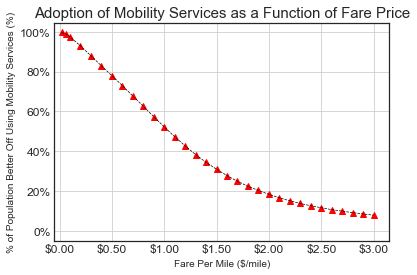

In [24]:
plt.style.use('seaborn-white')

# plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')

plt.plot([x[0] for x in cost_per_ride],[y[1] for y in cost_per_ride],
         'r^',[x[0] for x in cost_per_ride],[y[1] for y in cost_per_ride],'k--',
        linewidth=.7)

fmt = '${x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
ax=plt.gca()
plt.title('Adoption of Mobility Services as a Function of Fare Price',size=15)
ax.xaxis.set_major_formatter(tick) 

#Trying to format y axis
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.grid()
plt.ylabel('% of Population Better Off Using Mobility Services (%)',size=10)
plt.xlabel('Fare Per Mile ($/mile)',size=10)
fig=plt.gcf()
ax.set_ylim(ymin=-.05)
ax.set_xlim(xmin=-.05)

fig.savefig('functionoffareprice.png',dpi=500,facecolor=fig.get_facecolor())



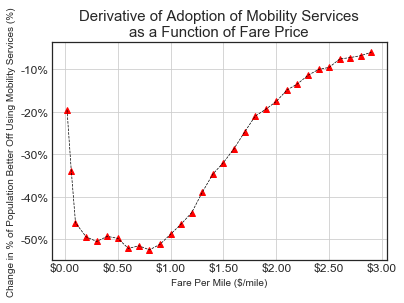

In [75]:
#Derivative Plot
deriv_cpr=[(cost_per_ride[x+1][1]-cost_per_ride[x][1])/(cost_per_ride[x+1][0]-cost_per_ride[x][0]) for x in range(len(cost_per_ride)-1)]

plt.plot([x[0] for x in cost_per_ride[:-1]],[y for y in deriv_cpr],
         'r^',[x[0] for x in cost_per_ride[:-1]],[y for y in deriv_cpr],'k--',
        linewidth=.7)

# print(len([x[0] for x in cost_per_ride[:-1]]))
# print(len([y for y in deriv_cpr]))

fmt = '${x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
ax=plt.gca()
plt.title('Derivative of Adoption of Mobility Services\nas a Function of Fare Price',size=15)

ax.xaxis.set_major_formatter(tick) 

#Trying to format y axis
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.grid()
plt.ylabel('Change in % of Population Better Off Using Mobility Services (%)',size=10)
plt.xlabel('Fare Per Mile ($/mile)',size=10)
fig=plt.gcf()
# ax.set_ylim(ymin=-.05)
# ax.set_xlim(xmin=-.05)
fig.savefig('deriv_functionoffareprice.png',dpi=500,facecolor=fig.get_facecolor())


In [25]:
###########################################################
#Producing Cost Per Ride to Percentage Plot
#More granular


cost_per_mile_2=np.arange(.01,.31,.01)
cost_per_ride_2=[]

for x in range(0,len(cost_per_mile_2)):

    #Monte Carlo Simulation
    output_year = (7,)
    Decision = np.zeros((1,simsize))
    Car_NPV = []
    Uber_NPV = []

    for i in range(0,simsize-1):
    #     print 'Time Worth', Time_Worth[i]
    #     print 'Annual_Miles_Avg Worth', Annual_Miles_Avg[i]
    #     print 'Car Price', Car_Price[i]

        a,b,c = Car_Ownsership_Expense_Model(outputyears=output_year,annualmiles = Annual_Miles_Avg[i],carprice=Car_Price[i],timeworth= Time_Worth[i], triptime= Trip_Time_Avg[i])
        d = Uber_Expense_Model(farepermile=cost_per_mile_2[x],outputyears= output_year,timeworth=Time_Worth[i],annualmiles=Annual_Miles_Avg[i],carprice = Car_Price[i],triptime= Trip_Time_Avg[i])
        Car_NPV.append(a)
        Uber_NPV.append(d)

    #     print 'Car Own Cost', a[0]
    #     print 'Uber Cost', d
        #d is expense of ubering
        Decision[0,i] = a[0]-d



    Decision = np.transpose(Decision)
    n_bins=100
    Decision=Decision/1000 


    Uber_wins = 0 
    Car_wins = 0
    for i in range(0,len(Decision)):
        if Decision[i] < 0:
            Car_wins += 1
        else:
            Uber_wins += 1

    Uber_percent = float(Uber_wins)/len(Decision)
    Car_percent = float(Car_wins)/len(Decision)
    
    print("Cost Per Mile is ", cost_per_mile[x])
    print(Uber_percent, 'of the US is better off Ubering')
    print(Car_percent, 'of the US is better off Car Owning')

    cost_per_ride_2.append((cost_per_mile_2[x],Uber_percent))


Cost Per Mile is  0.02
0.9974 of the US is better off Ubering
0.0026 of the US is better off Car Owning
Cost Per Mile is  0.06
0.99625 of the US is better off Ubering
0.00375 of the US is better off Car Owning
Cost Per Mile is  0.1
0.99496 of the US is better off Ubering
0.00504 of the US is better off Car Owning
Cost Per Mile is  0.2
0.99319 of the US is better off Ubering
0.00681 of the US is better off Car Owning
Cost Per Mile is  0.3
0.99101 of the US is better off Ubering
0.00899 of the US is better off Car Owning
Cost Per Mile is  0.4
0.98841 of the US is better off Ubering
0.01159 of the US is better off Car Owning
Cost Per Mile is  0.5
0.98543 of the US is better off Ubering
0.01457 of the US is better off Car Owning
Cost Per Mile is  0.6
0.98245 of the US is better off Ubering
0.01755 of the US is better off Car Owning
Cost Per Mile is  0.7
0.97852 of the US is better off Ubering
0.02148 of the US is better off Car Owning
Cost Per Mile is  0.8
0.97485 of the US is better off U

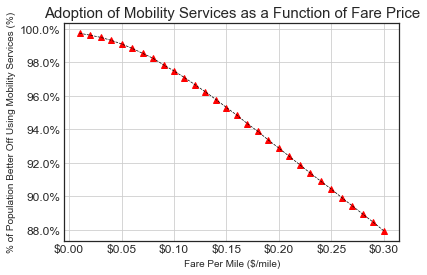

In [26]:
plt.style.use('seaborn-white')
# plt.style.use('dark_background')
# plt.style.use('fivethirtyeight')

plt.plot([x[0] for x in cost_per_ride_2],[y[1] for y in cost_per_ride_2],
         'r^',[x[0] for x in cost_per_ride_2],[y[1] for y in cost_per_ride_2],'k--',
        linewidth=.7)

fmt = '${x:,.2f}'
tick = mtick.StrMethodFormatter(fmt)
ax=plt.gca()
plt.title('Adoption of Mobility Services as a Function of Fare Price',size=15)
ax.xaxis.set_major_formatter(tick) 

#Trying to format y axis
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.ylabel('% of Population Better Off Using Mobility Services (%)',size=10)
plt.xlabel('Fare Per Mile ($/mile)',size=10)

ax.grid()
fig=plt.gcf()
fig.savefig('functionoffareprice_zoom.png',dpi=500,bbox_inches='tight',facecolor=fig.get_facecolor())